In [367]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)
import math
import warnings
from sklearn import linear_model

from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [393]:
# Grab and process the raw data.
#crimestats_baseline = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv')
crimestats_baseline = pd.read_csv('Thinkful 2_4 dataframe.csv')
crimestats = crimestats_baseline

In [371]:

crimestats.head(2)


,City,Population,Violent_Crime,Murder_and_Nonnegligent_Manslaughter,Rape_Legacy,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft
4,Adams Village,"1,861",0,0,0,0,0,12,2,10,0
5,Addison Town and Village,"2,577",3,0,0,0,3,24,3,20,1


In [394]:
# renaming the columns to fix the non-standard text in them
crimestats.columns = ['City', 'Population', 'Violent_Crime', 'Murder_and_Nonnegligent_Manslaughter', 'Rape_Revised','Rape_Legacy','Robbery','Aggravated_Assault','Property_Crime','Burglary','Larceny_Theft','Motor_Vehicle_Theft','Arson']

#dropping the first four rows to remove the non-numeric title fluff
crimestats.drop([0,1,2,3], axis=0, inplace=True)

#dropping the last three rows to remove the non-numeric title fluff
crimestats.drop([352,353,354], axis=0, inplace=True)

# dropping the Rape 1 column due to it not having any contents
crimestats.drop('Rape_Revised', axis=1, inplace=True)

# dropping the Arson column due to it having so many NaN values
crimestats.drop('Arson', axis=1, inplace=True)

# Remove 293: Seneca Falls Town due to the massive differential in per-1000-people burglary, property crime, 
# and larceny that it has relative to other cities.
# Remove 220: New York (city) because of just how much of an outlier it is from the rest of the cities.
crimestats.drop(293, axis=0, inplace=True)
crimestats.drop(220, axis=0, inplace=True)

# Removing outliers that showed up in model execution
crimestats.drop(7, axis=0, inplace=True)
crimestats.drop(11, axis=0, inplace=True)
crimestats.drop(39, axis=0, inplace=True)
crimestats.drop(130, axis=0, inplace=True)
crimestats.drop(276, axis=0, inplace=True)
crimestats.drop(314, axis=0, inplace=True)
crimestats.drop(350, axis=0, inplace=True)



In [395]:
# cleaning up the data by removing commas and changing the contents from str to int

def comma_cleaning_and_int(x):
    crimestats[x] = crimestats[x].str.replace(',', '')
    crimestats[x] = crimestats[x].astype(int)

comma_cleaning_and_int('Population')
comma_cleaning_and_int('Violent_Crime')
comma_cleaning_and_int('Murder_and_Nonnegligent_Manslaughter')
comma_cleaning_and_int('Rape_Legacy')
comma_cleaning_and_int('Robbery')
comma_cleaning_and_int('Aggravated_Assault')
comma_cleaning_and_int('Property_Crime')
comma_cleaning_and_int('Burglary')
comma_cleaning_and_int('Larceny_Theft')
comma_cleaning_and_int('Motor_Vehicle_Theft')


In [396]:
# adding in features requested in the drill

def yesno(x):
    if x > 0:
        return 1
    else:
        return 0

crimestats['murder_yesno'] = crimestats.apply(lambda row: yesno(row['Murder_and_Nonnegligent_Manslaughter']), axis=1)

crimestats['robbery_yesno'] = crimestats.apply(lambda row: yesno(row['Robbery']), axis=1)


In [397]:
# creating features using the ratio of crime to population

def popratio(x,y):
    return (1000*(x/y))

crimestats['violent_crime_per1000'] = 1000 * crimestats['Violent_Crime'] / crimestats['Population']

crimestats['murder_per1000'] = 1000 * crimestats['Murder_and_Nonnegligent_Manslaughter'] / crimestats['Population']

crimestats['rape_per1000'] = 1000 * crimestats['Rape_Legacy'] / crimestats['Population']

crimestats['robbery_per1000'] = 1000 * crimestats['Robbery'] / crimestats['Population']

crimestats['assault_per1000'] = 1000 * crimestats['Aggravated_Assault'] / crimestats['Population']

crimestats['propertycrime_per1000'] = 1000 * crimestats['Property_Crime'] / crimestats['Population']

crimestats['burglary_per1000'] = 1000 * crimestats['Burglary'] / crimestats['Population']

crimestats['larceny_per1000'] = 1000 * crimestats['Larceny_Theft'] / crimestats['Population']

crimestats['motorvehicle_crime_per1000'] = 1000 * crimestats['Motor_Vehicle_Theft'] / crimestats['Population']


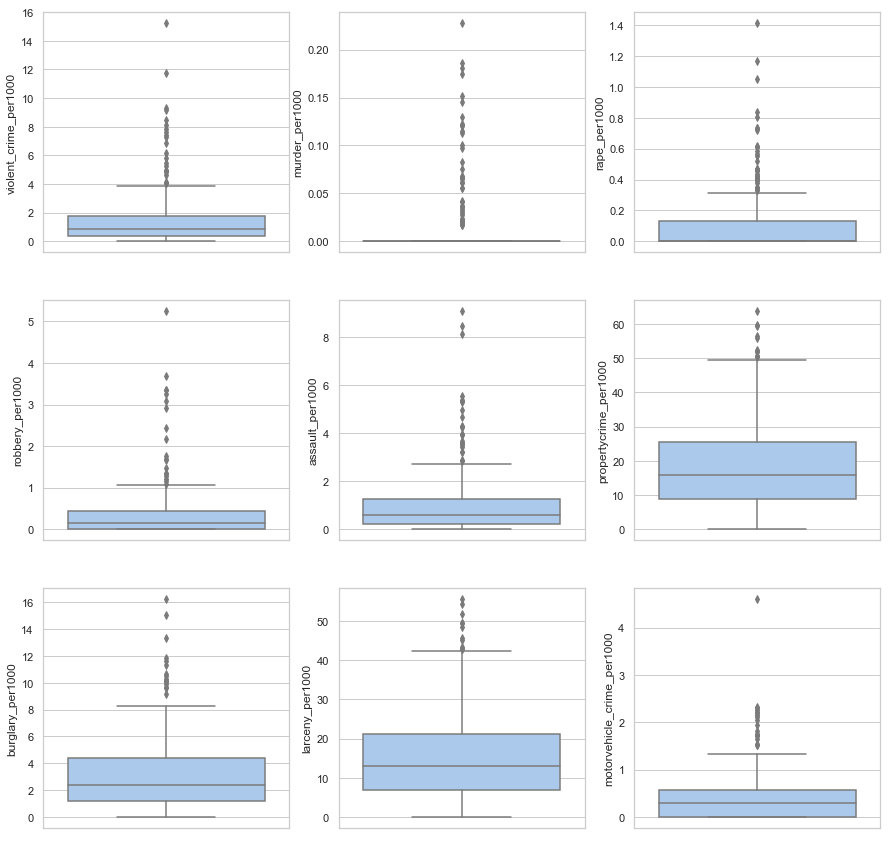

In [398]:
# boxplots to find the outliers in each per-1000 variable

sns.set(style="whitegrid")
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 1)
sns.boxplot(y = 'violent_crime_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 2)
sns.boxplot(y = 'murder_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 3)
sns.boxplot(y = 'rape_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 4)
sns.boxplot(y = 'robbery_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 5)
sns.boxplot(y = 'assault_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 6)
sns.boxplot(y = 'propertycrime_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 7)
sns.boxplot(y = 'burglary_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 8)
sns.boxplot(y = 'larceny_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 9)
sns.boxplot(y = 'motorvehicle_crime_per1000', data=crimestats, palette='pastel')  
plt.show()



In [399]:
# figuring out whether the outliers were specific cities, and whether or not they needed to be removed

print(crimestats.loc[crimestats['violent_crime_per1000'] > 10, ['City', 'violent_crime_per1000']])
print(' ')
print(crimestats.loc[crimestats['murder_per1000'] > .16, ['City', 'murder_per1000']])
print(' ')
print(crimestats.loc[crimestats['rape_per1000'] > 1, ['City', 'rape_per1000']])
print(' ')
print(crimestats.loc[crimestats['robbery_per1000'] > 4, ['City', 'robbery_per1000']])
print(' ')
print(crimestats.loc[crimestats['assault_per1000'] > 6, ['City', 'assault_per1000']])
print(' ')
print(crimestats.loc[crimestats['propertycrime_per1000'] > 60, ['City', 'propertycrime_per1000']])
print(' ')
print(crimestats.loc[crimestats['burglary_per1000'] > 15, ['City', 'burglary_per1000']])
print(' ')
print(crimestats.loc[crimestats['larceny_per1000'] > 55, ['City', 'larceny_per1000']])
print(' ')
print(crimestats.loc[crimestats['motorvehicle_crime_per1000'] > 3, ['City', 'motorvehicle_crime_per1000']])


              City  violent_crime_per1000
213       Newburgh                 15.225
222  Niagara Falls                 11.780
 
                     City  murder_per1000
144     Hempstead Village           0.181
213              Newburgh           0.175
266          Poughkeepsie           0.227
285  Saranac Lake Village           0.186
 
                 City  rape_per1000
145  Herkimer Village         1.170
184     Lyons Village         1.411
300    Sidney Village         1.051
 
         City  robbery_per1000
213  Newburgh            5.250
 
                  City  assault_per1000
213           Newburgh            9.065
222      Niagara Falls            8.129
348  Woodridge Village            8.444
 
                     City  propertycrime_per1000
159  Johnson City Village                 63.837
 
                   City  burglary_per1000
203  Monticello Village            16.256
222       Niagara Falls            15.048
 
                     City  larceny_per1000
159  Johnson City

In [400]:
crimestats['propertycrime_per1000_sqrt'] = crimestats['propertycrime_per1000']**.5
# crimestats['propertycrime_per1000_log'] = np.log(crimestats['propertycrime_per1000'])

In [448]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crimestats['Property_Crime'].values.reshape(-1, 1)
X = crimestats[['Population','propertycrime_per1000_sqrt', 'robbery_yesno', 'violent_crime_per1000', 'larceny_per1000']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 2.22499968e-02 -2.06503592e+01 -9.95300286e+01  5.10397433e+01
   1.37420313e+01]]

Intercept: 
 [-153.89390278]

R-squared:
0.8331482517668788


Feature selection is based on basic logic and trial-and-error.  

Population is critical otherwise the model has no basis for how much property crime to estimate for a city.  Property crime per 1000 (square root) is likewise a necessity for teaching the model how much property crime is normal for a city, without using any correlation with population size.  The square root was used because it produced a more normal residual result than the unmodified feature.

Robbery_yesno was used because it offered a categorical value for property-related crimes, and seemed to have a positive effect on the model.  Violent crime per 1000 was used because it offered another measure of crime that wasn't heavily correlated with property crime.  Larceny per 1000 was chosen during an experimental run because of its more-representational boxplot, and kept (despite its heavy correlation with property crime per 1000) because it seemed to reduce overfitting.


On a side note, I am uncertain as to how to merge two or more features into one using PCA.  Any suggestions or pointers would be appreciated.

In [451]:
predicted = regr.predict(X).ravel()
actual = crimestats['Property_Crime']
residual = actual - predicted

correlation_matrix = X.corr()
display(correlation_matrix)

# Cross Validation, 10 samples
sklearn.model_selection.cross_val_score(regr, X, Y, cv = 10)

,Population,propertycrime_per1000_sqrt,robbery_yesno,violent_crime_per1000,larceny_per1000
Population,1.000,0.186,0.458,0.305,0.131
propertycrime_per1000_sqrt,0.186,1.000,0.485,0.513,0.950
robbery_yesno,0.458,0.485,1.000,0.326,0.435
violent_crime_per1000,0.305,0.513,0.326,1.000,0.433
larceny_per1000,0.131,0.950,0.435,0.433,1.000


array([0.83682193, 0.8845385 , 0.53002457, 0.81486359, 0.83164823,
       0.76543859, 0.80814699, 0.43553427, 0.85978159, 0.84998471])

Cross validation seems to indicate there are still fitting issues with the model, as two of the ten results are around -.3 from the mean of the rest.

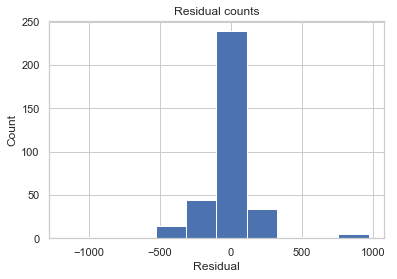

In [452]:
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

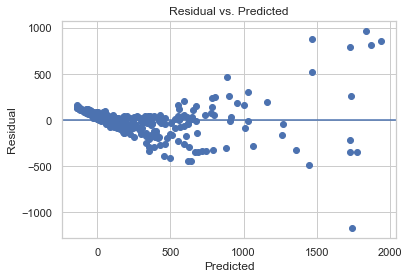

In [453]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()



(271, 5) (271, 1)
(68, 5) (68, 1)
Score: 0.871659516223968


Text(0, 0.5, 'Predictions')

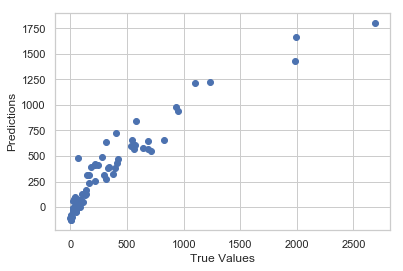

In [455]:
# Holdout, test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

model = regr.fit(X_train, y_train)
predictions = regr.predict(X_test)
print('Score: ' + str(model.score(X_test, y_test)))

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')



In [444]:
sklearn.metrics.mean_squared_error(actual, predicted)

31887.48788575339

In [445]:
# A survey of the predicted results to see which are excessive outliers; 
# most were removed in order to improve model performance.

cs_results = crimestats
cs_results['predictions'] = predicted

print(cs_results.loc[cs_results['predictions'] > 3000, ['City', 'Population','Property_Crime','predictions']])


Empty DataFrame
Columns: [City, Population, Property_Crime, predictions]
Index: []
